## Figure 4 - Leave One Image Out Analysis

We performed an analysis in which we held out each of the images that contained labeled cells individually.
There are 2,862 individual images.

Specifically, we trained multiclass models using the remaining 2,861 images and evaluated performance on the single held out example.
We visualize results here.

### Panels

- A: The distribution of probabilities per correct rank per feature space
- B: Per phenotype and feature space ranks and probabilities
- C: Per image, phenotype, and feature space ranks and probabilities
- D: High threshold to reduce false positives

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
# Set I/O
results_dir <- file.path("..", "3.evaluate_model", "evaluations", "LOIO_probas")

results_file <- file.path(results_dir, "compiled_LOIO_probabilites.tsv")
results_summary_file <- file.path(results_dir, "LOIO_summary_ranks.tsv")
results_summary_perphenotype_file <- file.path(results_dir, "LOIO_summary_ranks_perphenotype.tsv")

output_fig_loio <- file.path("figures", "main_figure_4_loio.png")

In [3]:
# Set constants
high_threshold <- 0.9

In [4]:
# Create phenotype categories dataframe
# Note: phenotype_categories defined in themes.r
phenotype_categories_df <- stack(phenotype_categories) %>%
  rename(Mitocheck_Category = ind, Mitocheck_Phenotypic_Class = values)

phenotype_categories_df

Mitocheck_Phenotypic_Class,Mitocheck_Category
<chr>,<fct>
Interphase,Interphase
Elongated,Interphase
Large,Interphase
Prometaphase,Mitosis
MetaphaseAlignment,Mitosis
Metaphase,Mitosis
Anaphase,Mitosis
Binuclear,Consequences
Polylobed,Consequences


### Panel A - Overall summary

In [5]:
loio_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Model_Phenotypic_Class" = "c",
        "Mitocheck_Phenotypic_Class" = "c",
        "Cell_UUID" = "c",
        "Metadata_DNA" = "c",
        "Model_Feature_Type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::group_by(
        Cell_UUID,
        Metadata_DNA,
        Mitocheck_Phenotypic_Class,
        Model_Feature_Type,
        Model_C,
        Model_l1_ratio
    ) %>%
    dplyr::mutate(rank_value = rank(desc(Predicted_Probability))) %>%
    dplyr::mutate(correct_pred = paste(Mitocheck_Phenotypic_Class == Model_Phenotypic_Class)) %>%
    dplyr::left_join(phenotype_categories_df, by = "Mitocheck_Phenotypic_Class") %>%
    dplyr::left_join(phenotype_categories_df, by = c("Model_Phenotypic_Class" = "Mitocheck_Phenotypic_Class"), suffix = c("", "_model")) %>%
    dplyr::mutate(correct_class_pred = paste(Mitocheck_Category == Mitocheck_Category_model))

loio_df$rank_value <- factor(loio_df$rank_value, levels = paste(sort(unique(loio_df$rank_value))))

loio_df$Model_Feature_Type <-
    dplyr::recode_factor(loio_df$Model_Feature_Type, !!!facet_labels)

refactor_logical <- c("TRUE" = "TRUE", "FALSE" = "FALSE")
loio_df$correct_pred <-
    dplyr::recode_factor(loio_df$correct_pred, !!!refactor_logical)

print(dim(loio_df))
head(loio_df, 5)

New names:
• `` -> `...1`


[1] 128790     13


Cell_UUID,Metadata_DNA,Mitocheck_Phenotypic_Class,Model_Feature_Type,Model_C,Model_l1_ratio,Model_Phenotypic_Class,Predicted_Probability,rank_value,correct_pred,Mitocheck_Category,Mitocheck_Category_model,correct_class_pred
<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,CellProfiler,10,0.2,ADCCM,5.697936e-06,7,FALSE,Interphase,Other,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,CellProfiler,10,0.2,Anaphase,1.622146e-01,2,FALSE,Interphase,Mitosis,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,CellProfiler,10,0.2,Apoptosis,8.078470e-01,1,FALSE,Interphase,Other,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,CellProfiler,10,0.2,Binuclear,1.129754e-13,15,FALSE,Interphase,Consequences,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,CellProfiler,10,0.2,Elongated,1.360021e-07,9,FALSE,Interphase,Interphase,TRUE


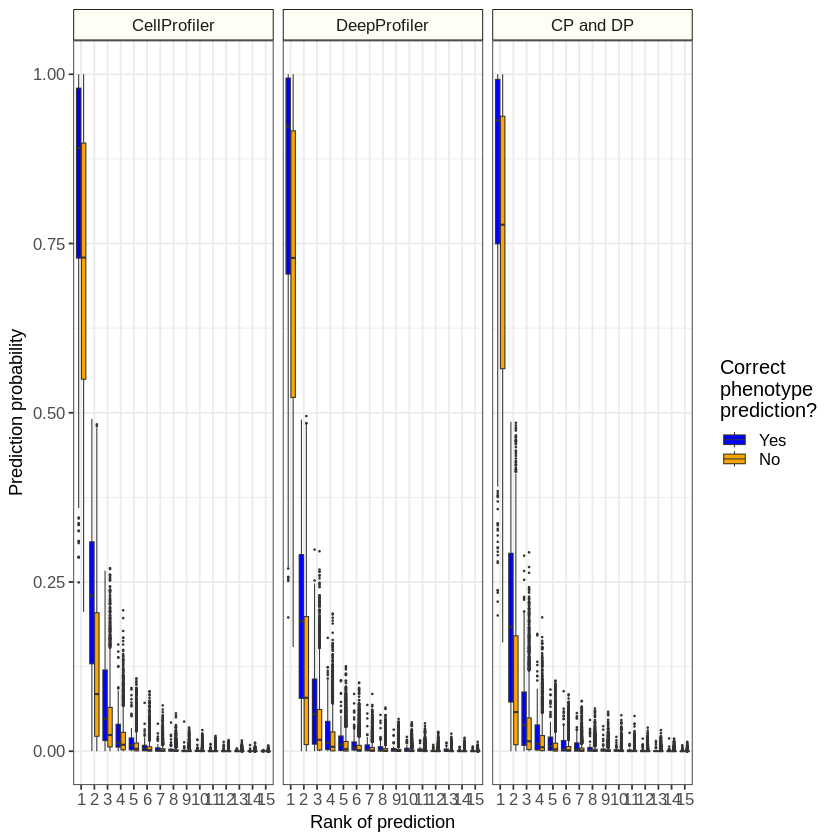

In [6]:
loio_feature_space_gg <- (
    ggplot(loio_df,
        aes(x = rank_value, y = Predicted_Probability)
          )
    + geom_boxplot(aes(fill = correct_pred), outlier.size = 0.1, lwd = 0.3)
    + theme_bw()
    + phenotypic_ggplot_theme
    + facet_grid("~Model_Feature_Type")
    + labs(x = "Rank of prediction", y = "Prediction probability")
    + scale_fill_manual(
        "Correct\nphenotype\nprediction?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
)

loio_feature_space_gg

## Panel B - Per image, per phenotype, and per feature space

In [7]:
# Load per image, per phenotype, per feature space summary
loio_summary_per_phenotype_df <- readr::read_tsv(
    results_summary_file,
    col_types = readr::cols(
        .default = "d",
        "Metadata_DNA" = "c",
        "Mitocheck_Phenotypic_Class" = "c",
        "Model_Feature_Type" = "c"
    )
) %>%
    dplyr::mutate(loio_label = "Leave one image out") %>%
    # Generate a new column that we will use for plotting
    # Note, we define focus_phenotypes in themes.r
    dplyr::mutate(Mitocheck_Plot_Label = if_else(
        Mitocheck_Phenotypic_Class %in% focus_phenotypes,
        Mitocheck_Phenotypic_Class,
        "Other"
    ))

feature_order <- c("CP" = "CP", "DP" = "DP", "CP_and_DP" = "CP_and_DP")

loio_summary_per_phenotype_df$Model_Feature_Type <-
    dplyr::recode_factor(loio_summary_per_phenotype_df$Model_Feature_Type, !!!feature_order)

loio_summary_per_phenotype_df$Mitocheck_Plot_Label <-
    dplyr::recode_factor(loio_summary_per_phenotype_df$Mitocheck_Plot_Label, !!!focus_phenotype_labels)

head(loio_summary_per_phenotype_df, 3)

Metadata_DNA,Mitocheck_Phenotypic_Class,Model_Feature_Type,Average_Rank,Average_P_Value,Min_IQR_Rank,Max_IQR_Rank,Min_IQR_P_Value,Max_IQR_P_Value,Count,loio_label,Mitocheck_Plot_Label
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
LT0003_40/LT0003_40_149_83.tif,Polylobed,CP,2.333333,0.6537640,1,3.0,0.4851124,0.9802650,3,Leave one image out,Other
LT0003_40/LT0003_40_149_83.tif,Polylobed,CP_and_DP,2.000000,0.6522797,1,2.5,0.4843529,0.9776095,3,Leave one image out,Other
LT0003_40/LT0003_40_149_83.tif,Polylobed,DP,1.333333,0.7480706,1,1.5,0.6322875,0.9792492,3,Leave one image out,Other


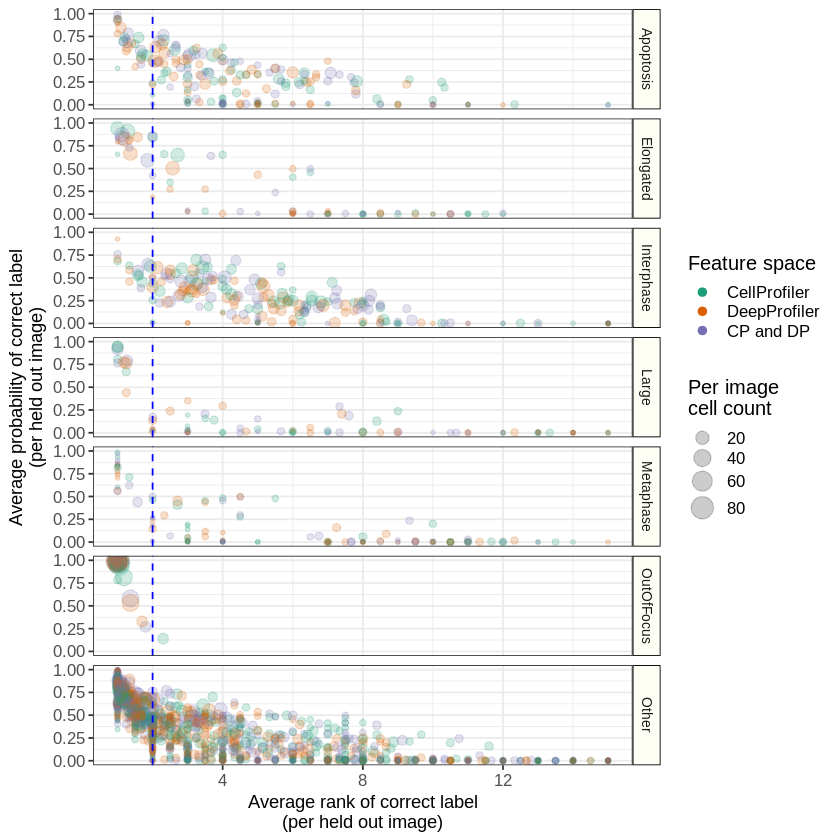

In [8]:
per_image_category_gg <- (
    ggplot(loio_summary_per_phenotype_df, aes(x = Average_Rank, y = Average_P_Value))
    + geom_point(aes(size = Count, color = Model_Feature_Type), alpha = 0.2)
    + theme_bw()
    + phenotypic_ggplot_theme
    + facet_grid("Mitocheck_Plot_Label")
    + labs(
        x = "Average rank of correct label\n(per held out image)",
        y = "Average probability of correct label\n(per held out image)"
    )
    + scale_color_manual(
        name = "Feature space",
        labels = facet_labels,
        values = facet_colors
    )
    + scale_size_continuous(
        name = "Per image\ncell count"
    )
    + geom_vline(xintercept=2, linetype = "dashed", color = "blue")
    + theme(
        strip.text.y = element_text(size = 8.3),
    )
    + guides(
        color = guide_legend(
            order = 1,
            override.aes = list(size = 2, alpha = 1)
        ),
        linetype = guide_legend(
            order = 2,
            override.aes = list(alpha = 1)
        ),
    )
)

per_image_category_gg

## Panel C - Setting high p value threshold to reduce false positives

In [9]:
phenotypic_class_category_counts <- loio_df %>%
    dplyr::select(Mitocheck_Phenotypic_Class, correct_pred, correct_class_pred) %>%
    dplyr::group_by(Mitocheck_Phenotypic_Class, correct_pred, correct_class_pred) %>%
    dplyr::summarize(phenotype_count = n()) %>%
    dplyr::ungroup()

loio_thresh_df <- loio_df %>%
    dplyr::mutate(pass_threshold = paste(Predicted_Probability >= high_threshold)) %>%
    dplyr::group_by(Mitocheck_Phenotypic_Class, correct_pred, correct_class_pred, pass_threshold) %>%
    dplyr::summarize(count = n()) %>%
    dplyr::left_join(phenotypic_class_category_counts, by = c("Mitocheck_Phenotypic_Class", "correct_pred", "correct_class_pred")) %>%
    dplyr::mutate(phenotype_prop = count / phenotype_count)

phenotypic_class_counts <- loio_df %>%
    dplyr::select(Mitocheck_Phenotypic_Class, correct_pred) %>%
    dplyr::group_by(Mitocheck_Phenotypic_Class, correct_pred) %>%
    dplyr::summarize(phenotype_count = n()) %>%
    dplyr::ungroup()

loio_thresh_df <- loio_df %>%
    dplyr::mutate(pass_threshold = paste(Predicted_Probability >= high_threshold)) %>%
    dplyr::group_by(Mitocheck_Phenotypic_Class, correct_pred, pass_threshold) %>%
    dplyr::summarize(count = n()) %>%
    dplyr::left_join(phenotypic_class_counts, by = c("Mitocheck_Phenotypic_Class", "correct_pred")) %>%
    dplyr::mutate(phenotype_prop = count / phenotype_count)

# Reverse order of predicted label for plotting
loio_thresh_df$Mitocheck_Phenotypic_Class <-
    factor(loio_thresh_df$Mitocheck_Phenotypic_Class, levels = rev(unique(loio_thresh_df$Mitocheck_Phenotypic_Class)))

head(loio_thresh_df)

Adding missing grouping variables: `Cell_UUID`, `Metadata_DNA`,
`Model_Feature_Type`, `Model_C`, `Model_l1_ratio`
`summarise()` has grouped output by 'Mitocheck_Phenotypic_Class',
'correct_pred'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Mitocheck_Phenotypic_Class',
'correct_pred', 'correct_class_pred'. You can override using the `.groups`
argument.
Adding missing grouping variables: `Cell_UUID`, `Metadata_DNA`,
`Model_Feature_Type`, `Model_C`, `Model_l1_ratio`
`summarise()` has grouped output by 'Mitocheck_Phenotypic_Class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Mitocheck_Phenotypic_Class',
'correct_pred'. You can override using the `.groups` argument.


Mitocheck_Phenotypic_Class,correct_pred,pass_threshold,count,phenotype_count,phenotype_prop
<fct>,<fct>,<chr>,<int>,<int>,<dbl>
ADCCM,TRUE,FALSE,245,285,0.859649123
ADCCM,TRUE,TRUE,40,285,0.140350877
ADCCM,FALSE,FALSE,3967,3990,0.994235589
ADCCM,FALSE,TRUE,23,3990,0.005764411
Anaphase,TRUE,FALSE,224,252,0.888888889
Anaphase,TRUE,TRUE,28,252,0.111111111


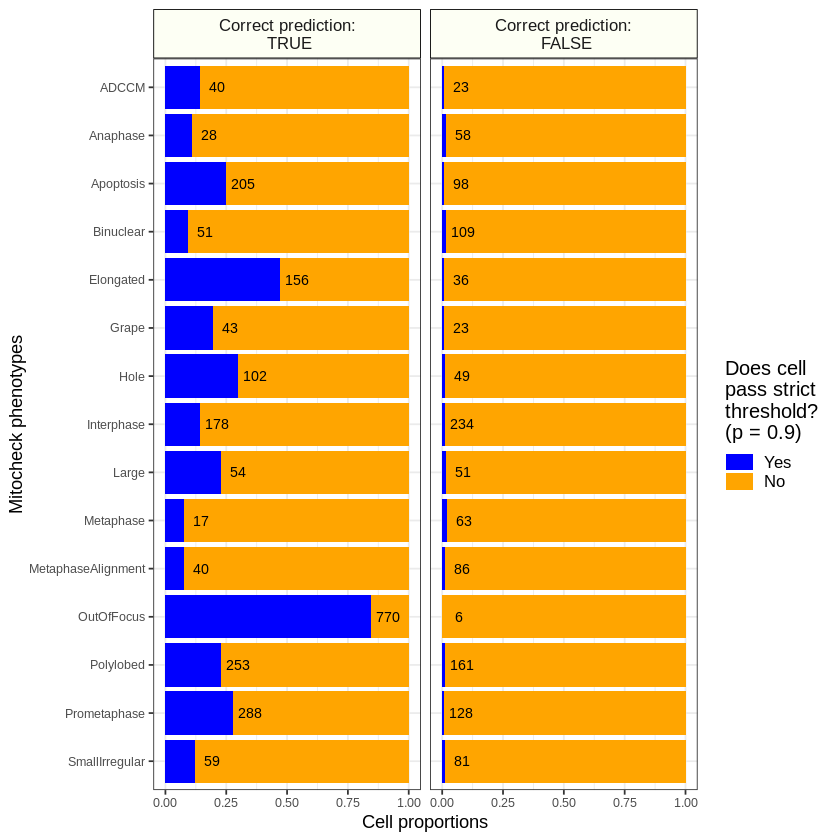

In [10]:
custom_labeller <- function(value) {
  paste("Correct prediction:\n", value)
}

correct_pred_proportion_gg <- (
    ggplot(
        loio_thresh_df,
        aes(
            x = phenotype_prop,
            y = Mitocheck_Phenotypic_Class,
            fill = pass_threshold
        )
    )
    + geom_bar(stat = "identity")
    + geom_text(
        data = loio_thresh_df %>%
            dplyr::filter(pass_threshold == TRUE),
        color = "black",
        aes(label = count),
        nudge_x = 0.07,
        size = 3
    )
    + facet_wrap("~correct_pred", labeller = labeller(correct_pred = custom_labeller))
    + theme_bw()
    + phenotypic_ggplot_theme
    + theme(axis.text = element_text(size = 7.5))
    + scale_fill_manual(
        paste0("Does cell\npass strict\nthreshold?\n(p = ", high_threshold, ")"),
        values = focus_corr_colors,
        labels = focus_corr_labels,
        breaks = c("TRUE", "FALSE")
    )
    + labs(x = "Cell proportions", y = "Mitocheck phenotypes")
)

correct_pred_proportion_gg

## Panel D - Of incorrect predictions, how many were correct categories?

In [11]:
same_class_wrong_pred_summary_df <- loio_df %>%
    dplyr::filter(correct_pred == "FALSE") %>%
    dplyr::filter(rank_value == 1) %>%
    dplyr::group_by(Mitocheck_Phenotypic_Class, correct_class_pred) %>%
    dplyr::summarize(count = n(), avg_prob = mean(Predicted_Probability)) %>%
    dplyr::ungroup() %>%
    dplyr::left_join(phenotype_categories_df, by = "Mitocheck_Phenotypic_Class") %>%
    dplyr::group_by(Mitocheck_Category, correct_class_pred) %>%
    dplyr::summarize(total_count = sum(count), avg_prob = mean(avg_prob))

phenotypic_category_counts <- same_class_wrong_pred_summary_df %>%
    dplyr::select(Mitocheck_Category, total_count) %>%
    dplyr::group_by(Mitocheck_Category) %>%
    dplyr::summarize(phenotype_category_count = sum(total_count)) %>%
    dplyr::ungroup()

same_class_wrong_pred_summary_df <- same_class_wrong_pred_summary_df %>%
    dplyr::left_join(phenotypic_category_counts, by = "Mitocheck_Category") %>%
    dplyr::mutate(category_proportion = total_count / phenotype_category_count)

same_class_wrong_pred_summary_df$Mitocheck_Category <- factor(
    same_class_wrong_pred_summary_df$Mitocheck_Category,
    levels = rev(levels(same_class_wrong_pred_summary_df$Mitocheck_Category))
)

head(same_class_wrong_pred_summary_df)

`summarise()` has grouped output by 'Mitocheck_Phenotypic_Class'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Mitocheck_Category'. You can override
using the `.groups` argument.


Mitocheck_Category,correct_class_pred,total_count,avg_prob,phenotype_category_count,category_proportion
<fct>,<chr>,<int>,<dbl>,<int>,<dbl>
Interphase,FALSE,908,0.7261397,1043,0.8705657
Interphase,TRUE,135,0.7374017,1043,0.1294343
Mitosis,FALSE,778,0.7345469,1140,0.6824561
Mitosis,TRUE,362,0.7154465,1140,0.3175439
Consequences,FALSE,664,0.7203246,1042,0.6372361
Consequences,TRUE,378,0.7231480,1042,0.3627639


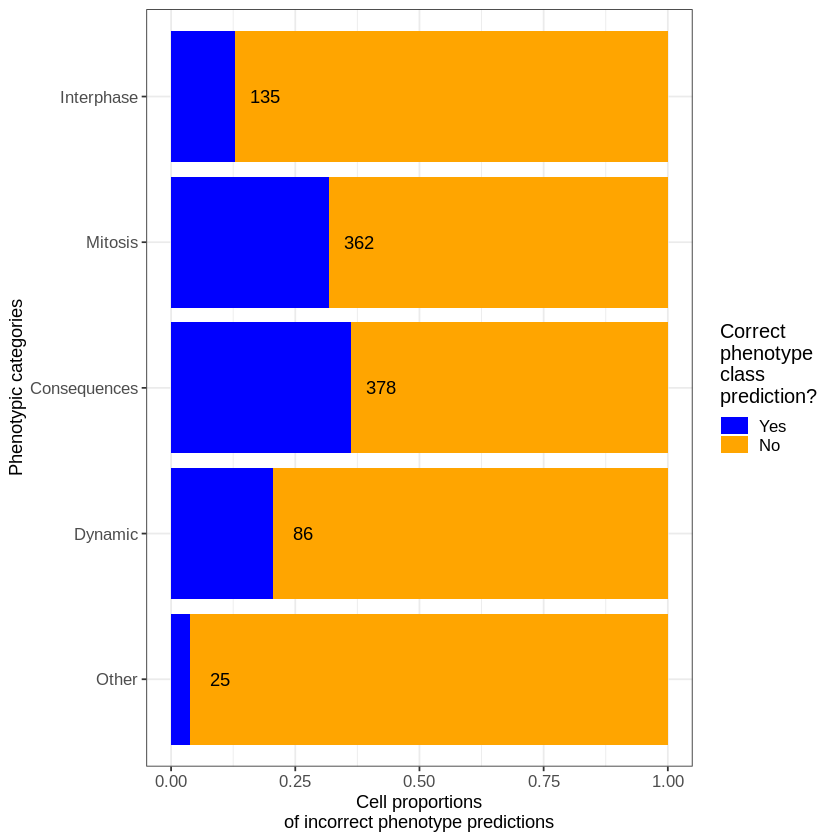

In [12]:
correct_class_phenotype_pred_gg <- (
    ggplot(
        same_class_wrong_pred_summary_df,
        aes(
            x = Mitocheck_Category,
            y = category_proportion,
            fill = correct_class_pred
        )
    )
    + geom_bar(stat = "identity")
    + geom_text(
        data = same_class_wrong_pred_summary_df %>%
            dplyr::filter(correct_class_pred == TRUE),
        color = "black",
        aes(label = total_count),
        nudge_y = 0.06
    )
    + coord_flip()
    + scale_fill_manual(
        "Correct\nphenotype\nclass\nprediction?",
        values = focus_corr_colors,
        labels = focus_corr_labels,
        breaks = c("TRUE", "FALSE")
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + labs(x = "Phenotypic categories", y = "Cell proportions\nof incorrect phenotype predictions")
)

correct_class_phenotype_pred_gg

## Output combined figure

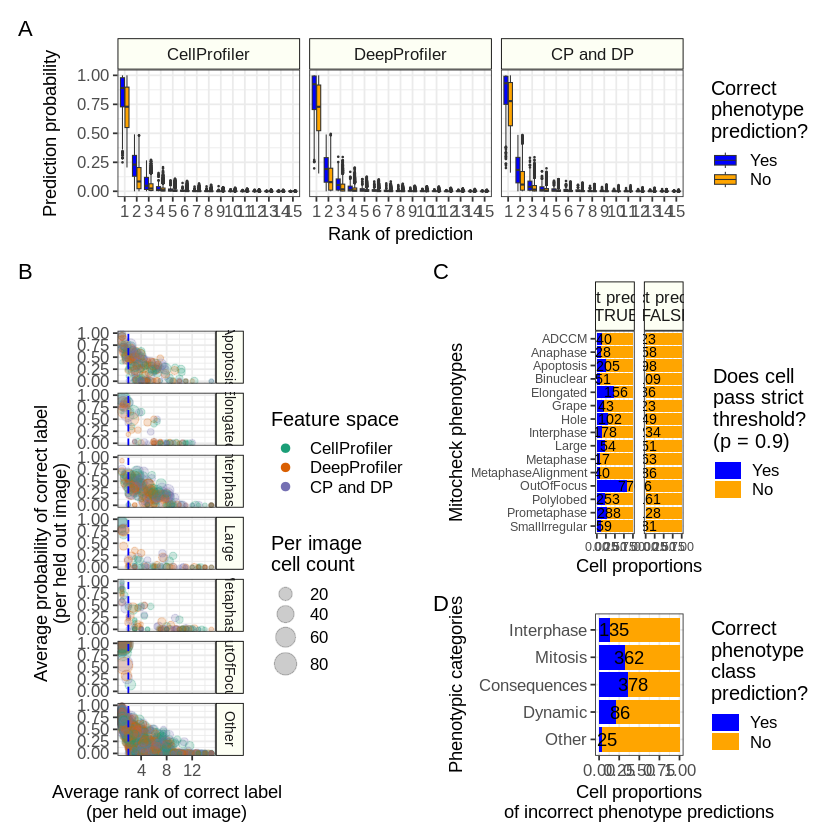

In [13]:
right_bottom_nested <- (
    correct_pred_proportion_gg / correct_class_phenotype_pred_gg
) + plot_layout(heights = c(1, 0.7)) 

bottom_nested <- (
    per_image_category_gg | right_bottom_nested
) + plot_layout(widths = c(1, 0.9))

compiled_fig <- (
    loio_feature_space_gg /
    bottom_nested
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(0.3, 1)) 

ggsave(output_fig_loio, dpi = 500, height = 10, width = 12)

compiled_fig